In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from typing import Tuple

import warnings
warnings.filterwarnings("ignore")

In [2]:
# File paths
PATH = "../dataset"
DATA_FILENAME = f"{PATH}/data.csv"

SEED = 42

# Load the dataset from CSV file
df = pd.read_csv(DATA_FILENAME)

SEASONAL_PERIODS= 365
STEPS_TO_FORECAST = 900

set2_palette = sns.color_palette("Set2")
palette = [set2_palette[2], set2_palette[1]]
sns.set_palette(palette)

## Auxiliary Functions

In [3]:
def create_lagged_features(series, n_lags=5):
    df = pd.DataFrame({'y': series})
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['y'].shift(i)
    df.dropna(inplace=True)
    return df

In [4]:
def train_and_evaluate_svr(df_train, df_test, n_lags=5, kernel='rbf', C=100, gamma=0.1, epsilon=0.1):
    """
    Train and evaluate an SVR model on lagged features of the residual series.

    Parameters:
        df_train (pd.Series): Training series.
        df_test (pd.Series): Testing series.
        n_lags (int): Number of lagged features to create.
        test_split_ratio (float): Ratio for train-test split.
        kernel (str): Kernel type for SVR.
        C (float): Regularization parameter for SVR.
        gamma (float): Kernel coefficient for SVR.
        epsilon (float): Epsilon in the epsilon-SVR model.

    Returns:
        np.ndarray: Forecasted residuals for the test set.
    """
    # Create lagged feature dataframe
    df_lagged = create_lagged_features(pd.concat([df_train, df_test]), n_lags=n_lags)

    # Train-test split (time-aware)
    split = int(len(df_lagged) * 0.8)
    train_df = df_lagged.iloc[:split]
    test_df = df_lagged.iloc[split:]

    X_train = train_df.drop(columns='y').values
    y_train = train_df['y'].values
    X_test = test_df.drop(columns='y').values
    y_test = test_df['y'].values

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVR
    svm_model = SVR(kernel=kernel, C=C, gamma=gamma, epsilon=epsilon)
    svm_model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = svm_model.predict(X_test_scaled)

    return y_pred

In [5]:
def train_exponential_smoothing_trend(df_train: pd.Series):
    """
    Train and plot an Exponential Smoothing model with additive damped trend.

    Parameters:
        df_train (pd.Series): Training data.

    Returns:
        tuple: (model, forecast, success_flag)
    """
    try:
        # Initialize the model
        model = ExponentialSmoothing(df_train.values,
                                      trend='additive',
                                      damped=False,
                                      seasonal=None)
        # Fit the model
        fitted_model = model.fit(smoothing_level=None,
                                 smoothing_slope=None,
                                 damping_slope=None)

        # Check if optimization was successful
        if fitted_model.mle_retvals.success:
            forecast = fitted_model.forecast(STEPS_TO_FORECAST)

            # Check for NaN values in the forecast
            if not np.isnan(forecast).any():
                return fitted_model, forecast, True
            else:
                print('RuntimeWarning: invalid value encountered in forecast.')
                return fitted_model, None, False
        else:
            print('ConvergenceWarning: Optimization failed to converge.')
            return None, None, False
    except Exception as e:
        print(f"Error: {e}")
        return None, None, False

In [6]:
def train_exponential_smoothing_seasonality(df_train: pd.Series):
    """
    Train and plot an Exponential Smoothing model with multiplicative seasonality.

    Parameters:
        df_train (pd.Series): Training data.

    Returns:
        tuple: (model, forecast, success_flag)
    """
    try:
        # Initialize the model
        model = ExponentialSmoothing(df_train.values,
                                      trend=None,
                                      damped=False,
                                      seasonal='mul',
                                      seasonal_periods=SEASONAL_PERIODS)
        # Fit the model
        fitted_model = model.fit(smoothing_level=None,
                                 smoothing_seasonal=None)

        # Check if optimization was successful
        if fitted_model.mle_retvals.success:
            forecast = fitted_model.forecast(STEPS_TO_FORECAST)

            # Check for NaN values in the forecast
            if not np.isnan(forecast).any():
                return fitted_model, forecast, True
            else:
                print('RuntimeWarning: invalid value encountered in forecast.')
                return fitted_model, None, False
        else:
            print('ConvergenceWarning: Optimization failed to converge.')
            return None, None, False
    except Exception as e:
        print(f"Error: {e}")
        return None, None, False

In [7]:
def train_and_forecast_mlp(df_train, df_test, hidden_layer_size: Tuple[int, int], n_lags=5, seed=None):

    # Create lagged feature dataframe
    test_split_ratio = 0.8
    activation = 'relu'
    solver = 'adam'
    max_iter = 1000
    random_state = seed
    df_lagged = create_lagged_features(pd.concat([df_train, df_test]), n_lags=n_lags)

    # Train-test split (time-aware)
    split = int(len(df_lagged) * test_split_ratio)
    train_df = df_lagged.iloc[:split]
    test_df = df_lagged.iloc[split:]

    X_train = train_df.drop('y', axis=1).values
    y_train = train_df['y'].values
    X_test = test_df.drop('y', axis=1).values

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train MLP Regressor
    mlp_model = MLPRegressor(hidden_layer_sizes=hidden_layer_size, activation=activation,
                             solver=solver, max_iter=max_iter, random_state=random_state)
    mlp_model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = mlp_model.predict(X_test_scaled)

    return y_pred


## Dataset

In [8]:
df_renewable = df['producao_renovavel']
df_non_renewable = df['producao_nao_renovavel']

##  Prediction

### Renewable Time Series

In [9]:
# First, perform the decomposition for non-renewable energy
decomposition_renewable = seasonal_decompose(df_renewable, model='multiplicative', period=SEASONAL_PERIODS)

# Extract the components with consistent naming
# Remove values before the first trend index
trend_component = decomposition_renewable.trend.dropna().rename("trend")
first_trend_index = trend_component.index[0]

# Align seasonal and residual components with the trend component
seasonal_component = decomposition_renewable.seasonal[first_trend_index:].rename("seasonal")
residual_component = decomposition_renewable.resid[first_trend_index:].rename("residual")

# Fixate the last value index of the trend component
last_trend_index = trend_component.index[-1]
seasonal_component = seasonal_component[:last_trend_index].rename("seasonal")
residual_component = residual_component[:last_trend_index].rename("residual")

# Split each component into training and testing sets
split_ratio = 0.8
split_index = int(len(trend_component) * split_ratio)


trend_train, trend_test = trend_component[:split_index], trend_component[split_index:]
seasonal_train, seasonal_test = seasonal_component[:split_index], seasonal_component[split_index:]
residual_train, residual_test = residual_component[:split_index], residual_component[split_index:]

In [10]:
trend_model, trend_forecast_es, trend_success = train_exponential_smoothing_trend(trend_train)

residual_forecast_mlp = train_and_forecast_mlp(
    trend_train,
    trend_test,
    hidden_layer_size=(65, 85),
    n_lags=4,
    seed=SEED
)

In [11]:
trend_forecast_mlp = train_and_forecast_mlp(
    trend_train,
    trend_test,
    hidden_layer_size=(15, 15),
    seed=SEED
)
seasonal_model, seasonal_forecast, seasonal_success = train_exponential_smoothing_seasonality(seasonal_train)
residual_forecast_svr = train_and_evaluate_svr(
    residual_train,
    residual_test,
    n_lags=3,
    C=0.1,
    epsilon=0.0117,
    gamma="auto"
)

forecast_dates = trend_test.index[:STEPS_TO_FORECAST]
combined_forecast = np.zeros(STEPS_TO_FORECAST)
actual_test_data = df_renewable.loc[forecast_dates]

for i in range(STEPS_TO_FORECAST):
    if i < len(trend_forecast_mlp) and i < len(seasonal_forecast) and i < len(residual_forecast_svr):
        
        combined_forecast[i] = trend_forecast_mlp[i] * seasonal_forecast[i] *  residual_forecast_svr[i]

# Create a pandas Series with the forecast
final_forecast = pd.Series(combined_forecast, index=forecast_dates)

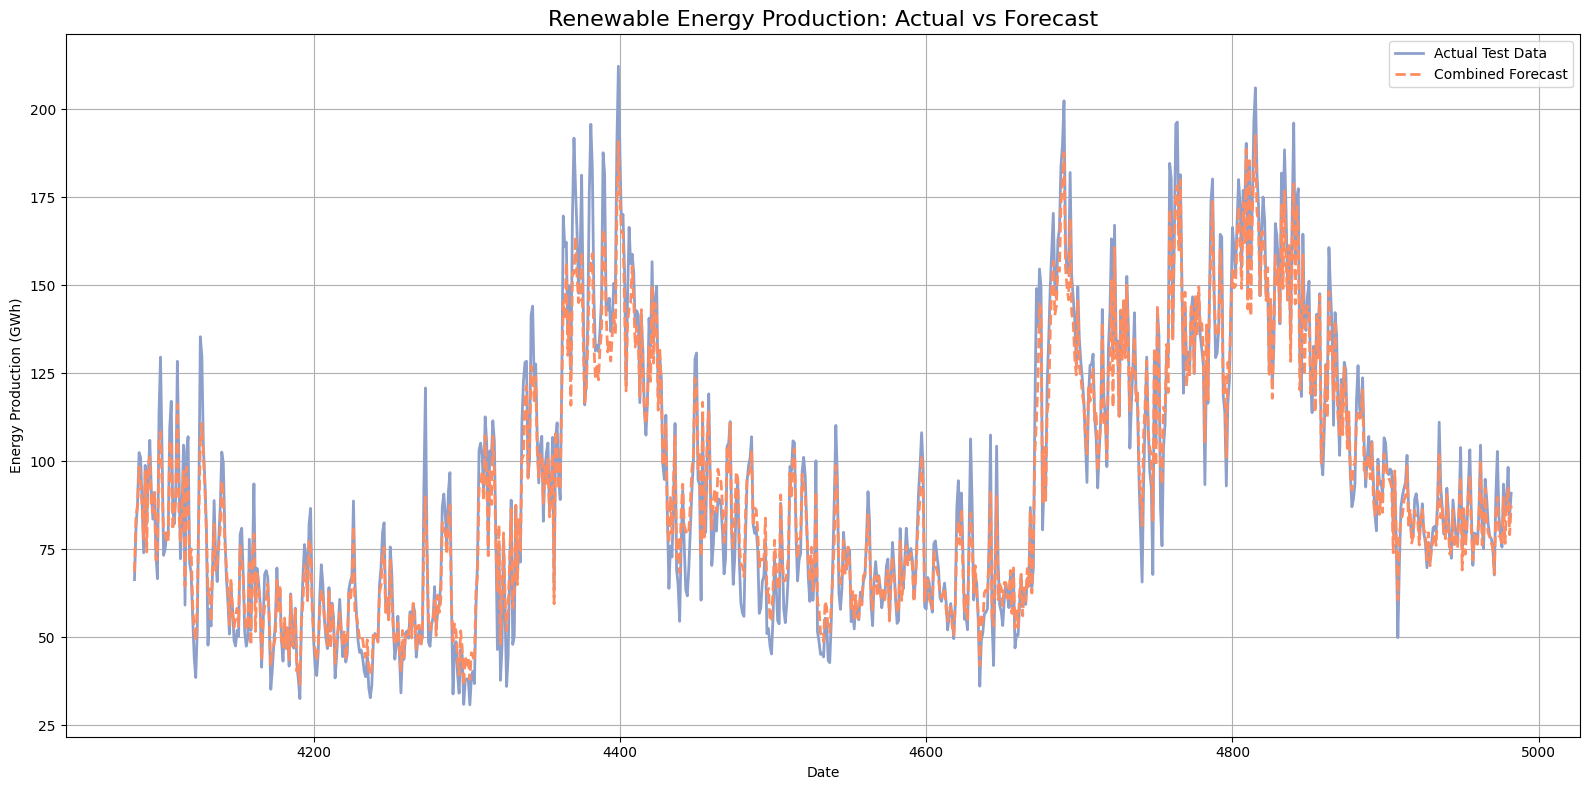


Forecast Accuracy Metrics:
MSE: 57.1472
RMSE: 7.5596
MAE: 5.6194
MAPE: 6.44%
R-squared: 0.9624


In [12]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(actual_test_data, label='Actual Test Data', linewidth=2)
plt.plot(final_forecast, '--', label='Combined Forecast', linewidth=2)
plt.title('Renewable Energy Production: Actual vs Forecast', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Energy Production (GWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate forecast accuracy metrics
# Align the lengths of actual_test_data and final_forecast
actual_test_data_aligned = actual_test_data.iloc[:len(final_forecast)]
mse = mean_squared_error(actual_test_data_aligned, final_forecast)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual_test_data - final_forecast))

# Avoid division by zero in MAPE calculation
if (actual_test_data == 0).any():
    print("Warning: Division by zero encountered in MAPE calculation.")
    mape = np.nan
else:
    mape = np.mean(np.abs((actual_test_data - final_forecast) / actual_test_data)) * 100

print(f"\nForecast Accuracy Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
# Calculate R-squared
r_squared = r2_score(actual_test_data_aligned, final_forecast)

print(f"R-squared: {r_squared:.4f}")

#### Hybrid Model Combination Analysis

In [13]:
# Ensure indices align between actual test data and forecast
forecast_dates = trend_test.index[:STEPS_TO_FORECAST]
actual_test_data = df_renewable.loc[forecast_dates]

# Define combinations of models for each component
trend_forecasts = [("MLP", trend_forecast_mlp), ("ETS", trend_forecast_es)]
seasonal_forecasts = [("ETS", seasonal_forecast)]
residual_forecasts = [("MLP", residual_forecast_mlp), ("SVR", residual_forecast_svr)]

# Initialize a dictionary to store metrics for each combination
metrics = {}

# Iterate through all combinations of forecasts
for trend_name, trend_forecast in trend_forecasts:
    for seasonal_name, seasonal_forecast in seasonal_forecasts:
        for residual_name, residual_forecast in residual_forecasts:
            # Combine forecasts
            combined_forecast = np.zeros(STEPS_TO_FORECAST)
            for t in range(STEPS_TO_FORECAST):
                if t < len(trend_forecast) and t < len(seasonal_forecast) and t < len(residual_forecast):
                    combined_forecast[t] = trend_forecast[t] * seasonal_forecast[t] * residual_forecast[t]

            # Create a pandas Series with the forecast
            final_forecast = pd.Series(combined_forecast, index=forecast_dates)

            # Calculate forecast accuracy metrics
            # Align the lengths of actual_test_data and final_forecast
            actual_test_data_aligned = actual_test_data.iloc[:len(final_forecast)]
            mse = mean_squared_error(actual_test_data_aligned, final_forecast)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(actual_test_data_aligned - final_forecast))

            # Avoid division by zero in MAPE calculation
            if (actual_test_data_aligned == 0).any():
                print("Warning: Division by zero encountered in MAPE calculation.")
                mape = np.nan
            else:
                mape = np.mean(np.abs((actual_test_data_aligned - final_forecast) / actual_test_data_aligned)) * 100

            # Calculate R-squared
            ss_total = np.sum((actual_test_data_aligned - actual_test_data_aligned.mean())**2)
            ss_residual = np.sum((actual_test_data_aligned - final_forecast)**2)
            r_squared = 1 - (ss_residual / ss_total)

            # Store metrics for this combination
            combination_name = f'Trend: {trend_name}, Seasonal: {seasonal_name}, Residual: {residual_name}'
            metrics[combination_name] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'R-squared': r_squared
            }

            # Print metrics
            print(f"\nForecast Accuracy Metrics for {combination_name}:")
            print(f"MSE: {mse:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"MAPE: {mape:.2f}%")
            print(f"R-squared: {r_squared:.4f}")


Forecast Accuracy Metrics for Trend: MLP, Seasonal: ETS, Residual: MLP:
MSE: 133541748.3005
RMSE: 11556.0265
MAE: 10236.2367
MAPE: 11065.85%
R-squared: -87841.1916

Forecast Accuracy Metrics for Trend: MLP, Seasonal: ETS, Residual: SVR:
MSE: 57.1472
RMSE: 7.5596
MAE: 5.6194
MAPE: 6.44%
R-squared: 0.9624

Forecast Accuracy Metrics for Trend: ETS, Seasonal: ETS, Residual: MLP:
MSE: 107956042.8151
RMSE: 10390.1897
MAE: 9375.6057
MAPE: 10249.86%
R-squared: -71011.2154

Forecast Accuracy Metrics for Trend: ETS, Seasonal: ETS, Residual: SVR:
MSE: 186.7366
RMSE: 13.6652
MAE: 10.1310
MAPE: 9.57%
R-squared: 0.8772


### Non-renewable Time Series

In [14]:
# First, perform the decomposition for non-renewable energy
decomposition_renewable = seasonal_decompose(df_non_renewable, model='multiplicative', period=SEASONAL_PERIODS)

# Extract the components with consistent naming
# Remove values before the first trend index
trend_component = decomposition_renewable.trend.dropna().rename("trend")
first_trend_index = trend_component.index[0]

# Align seasonal and residual components with the trend component
seasonal_component = decomposition_renewable.seasonal[first_trend_index:].rename("seasonal")
residual_component = decomposition_renewable.resid[first_trend_index:].rename("residual")

# Fixate the last value index of the trend component
last_trend_index = trend_component.index[-1]
seasonal_component = seasonal_component[:last_trend_index].rename("seasonal")
residual_component = residual_component[:last_trend_index].rename("residual")

# Split each component into training and testing sets
split_ratio = 0.8
split_index = int(len(trend_component) * split_ratio)


trend_train, trend_test = trend_component[:split_index], trend_component[split_index:]
seasonal_train, seasonal_test = seasonal_component[:split_index], seasonal_component[split_index:]
residual_train, residual_test = residual_component[:split_index], residual_component[split_index:]

In [ ]:
trend_forecast_mlp = train_and_forecast_mlp(
    trend_train,
    trend_test,
    hidden_layer_size=(25, 45),
    n_lags=5,
    seed=SEED
)

residual_forecast_mlp = train_and_forecast_mlp(
    trend_train,
    trend_test,
    hidden_layer_size=(65, 85),
    n_lags=4,
    seed=SEED
)

In [16]:
trend_model, trend_forecast_es, trend_success = train_exponential_smoothing_trend(trend_train)
seasonal_model, seasonal_forecast, seasonal_success = train_exponential_smoothing_seasonality(seasonal_train)
residual_forecast_svr = train_and_evaluate_svr(
    residual_train,
    residual_test,
    n_lags=3,
    C=18.,
    epsilon=0.01,
    gamma=0.02
)

forecast_dates = trend_test.index[:STEPS_TO_FORECAST]
combined_forecast = np.zeros(STEPS_TO_FORECAST)
actual_test_data = df_renewable.loc[forecast_dates]

for i in range(STEPS_TO_FORECAST):
    if i < len(trend_forecast_es) and i < len(seasonal_forecast) and i < len(residual_forecast_svr):
        combined_forecast[i] = trend_forecast_es[i] * seasonal_forecast[i] * residual_forecast_svr[i]

# Create a pandas Series with the forecast
final_forecast = pd.Series(combined_forecast, index=forecast_dates)

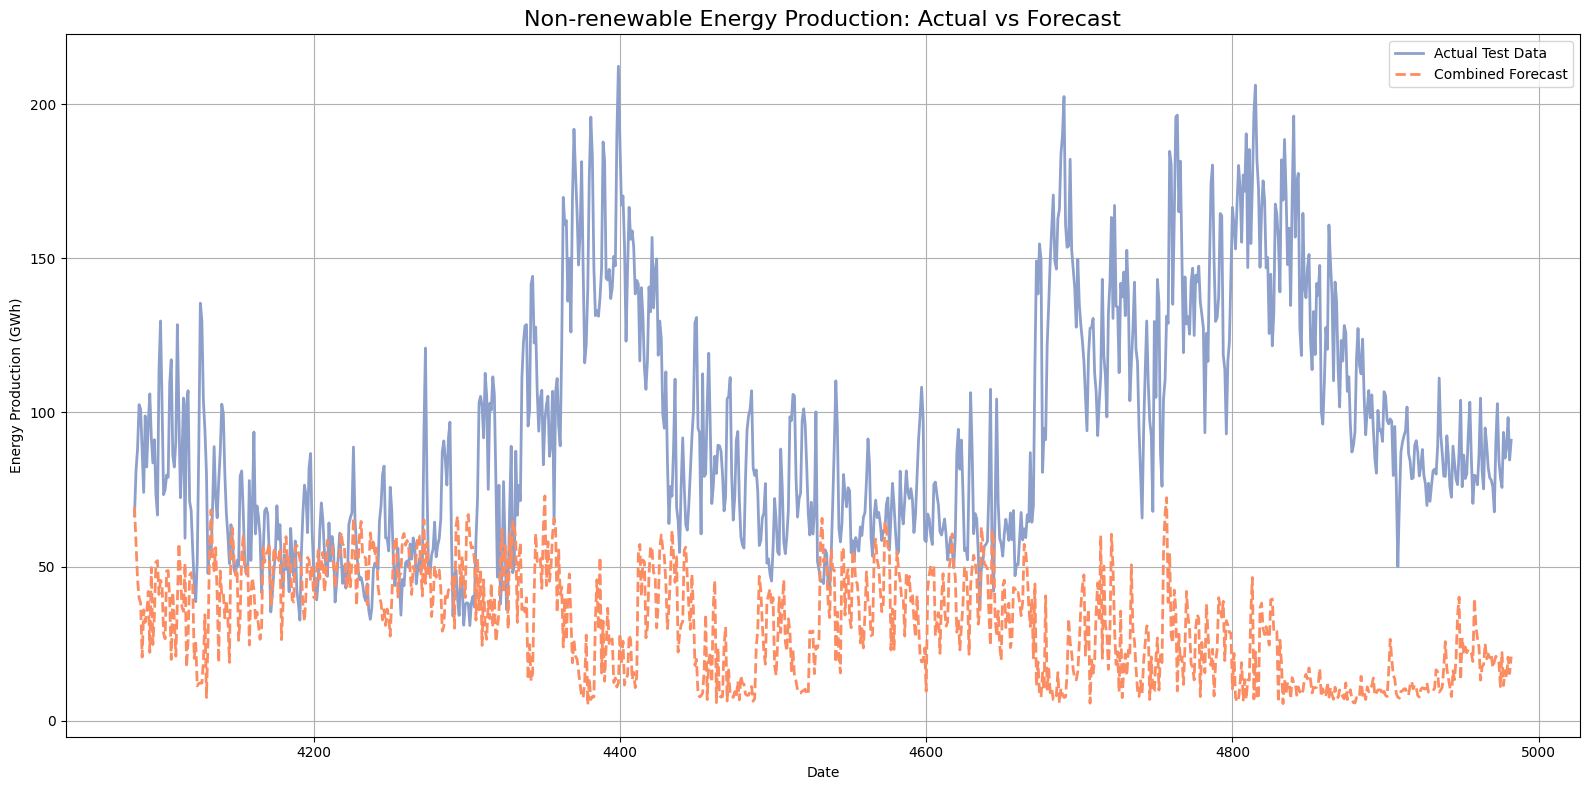


Forecast Accuracy Metrics:
MSE: 6369.0786
RMSE: 79.8065
MAE: 64.4864
MAPE: 60.20%
R-squared: -3.1895


In [17]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(actual_test_data, label='Actual Test Data', linewidth=2)
plt.plot(final_forecast, '--', label='Combined Forecast', linewidth=2)
plt.title('Non-renewable Energy Production: Actual vs Forecast', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Energy Production (GWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate forecast accuracy metrics
# Align the lengths of actual_test_data and final_forecast
actual_test_data_aligned = actual_test_data.iloc[:len(final_forecast)]
mse = mean_squared_error(actual_test_data_aligned, final_forecast)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual_test_data - final_forecast))

# Avoid division by zero in MAPE calculation
if (actual_test_data == 0).any():
    print("Warning: Division by zero encountered in MAPE calculation.")
    mape = np.nan
else:
    mape = np.mean(np.abs((actual_test_data - final_forecast) / actual_test_data)) * 100

print(f"\nForecast Accuracy Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
# Calculate R-squared
r_squared = r2_score(actual_test_data_aligned, final_forecast)

print(f"R-squared: {r_squared:.4f}")

#### Hybrid Model Combination Analysis

In [18]:
# Ensure indices align between actual test data and forecast
forecast_dates = trend_test.index[:STEPS_TO_FORECAST]
actual_test_data = df_renewable.loc[forecast_dates]

# Define combinations of models for each component
trend_forecasts = [("MLP", trend_forecast_mlp), ("ETS", trend_forecast_es)]
seasonal_forecasts = [("ETS", seasonal_forecast)]
residual_forecasts = [("MLP", residual_forecast_mlp), ("SVR", residual_forecast_svr)]

# Initialize a dictionary to store metrics for each combination
metrics = {}

# Iterate through all combinations of forecasts
for trend_name, trend_forecast in trend_forecasts:
    for seasonal_name, seasonal_forecast in seasonal_forecasts:
        for residual_name, residual_forecast in residual_forecasts:
            # Combine forecasts
            combined_forecast = np.zeros(STEPS_TO_FORECAST)
            for t in range(STEPS_TO_FORECAST):
                if t < len(trend_forecast) and t < len(seasonal_forecast) and t < len(residual_forecast):
                    combined_forecast[t] = trend_forecast[t] * seasonal_forecast[t] * residual_forecast[t]

            # Create a pandas Series with the forecast
            final_forecast = pd.Series(combined_forecast, index=forecast_dates)

            # Calculate forecast accuracy metrics
            # Align the lengths of actual_test_data and final_forecast
            actual_test_data_aligned = actual_test_data.iloc[:len(final_forecast)]
            mse = mean_squared_error(actual_test_data_aligned, final_forecast)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(actual_test_data_aligned - final_forecast))

            # Avoid division by zero in MAPE calculation
            if (actual_test_data_aligned == 0).any():
                print("Warning: Division by zero encountered in MAPE calculation.")
                mape = np.nan
            else:
                mape = np.mean(np.abs((actual_test_data_aligned - final_forecast) / actual_test_data_aligned)) * 100

            # Calculate R-squared
            ss_total = np.sum((actual_test_data_aligned - actual_test_data_aligned.mean())**2)
            ss_residual = np.sum((actual_test_data_aligned - final_forecast)**2)
            r_squared = 1 - (ss_residual / ss_total)

            # Store metrics for this combination
            combination_name = f'Trend: {trend_name}, Seasonal: {seasonal_name}, Residual: {residual_name}'
            metrics[combination_name] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'R-squared': r_squared
            }

            # Print metrics
            print(f"\nForecast Accuracy Metrics for {combination_name}:")
            print(f"MSE: {mse:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"MAPE: {mape:.2f}%")
            print(f"R-squared: {r_squared:.4f}")


Forecast Accuracy Metrics for Trend: MLP, Seasonal: ETS, Residual: MLP:
MSE: 2566560.8784
RMSE: 1602.0490
MAE: 1544.4828
MAPE: 2074.51%
R-squared: -1687.2536

Forecast Accuracy Metrics for Trend: MLP, Seasonal: ETS, Residual: SVR:
MSE: 5989.0798
RMSE: 77.3891
MAE: 61.7941
MAPE: 57.46%
R-squared: -2.9395

Forecast Accuracy Metrics for Trend: ETS, Seasonal: ETS, Residual: MLP:
MSE: 2053145.8525
RMSE: 1432.8803
MAE: 1364.6390
MAPE: 1859.25%
R-squared: -1349.5352

Forecast Accuracy Metrics for Trend: ETS, Seasonal: ETS, Residual: SVR:
MSE: 6369.0786
RMSE: 79.8065
MAE: 64.4864
MAPE: 60.20%
R-squared: -3.1895


## Complexity Analysis

Since the hybrid model did not perform well with Non-renewable energy production generalization, it will not be considered for this complexity analysis.

In [32]:
# First, perform the decomposition for non-renewable energy
decomposition_renewable = seasonal_decompose(df_renewable, model='multiplicative', period=SEASONAL_PERIODS)

# Extract the components with consistent naming
# Remove values before the first trend index
trend_component = decomposition_renewable.trend.dropna().rename("trend")
first_trend_index = trend_component.index[0]

# Align seasonal and residual components with the trend component
seasonal_component = decomposition_renewable.seasonal[first_trend_index:].rename("seasonal")
residual_component = decomposition_renewable.resid[first_trend_index:].rename("residual")

# Fixate the last value index of the trend component
last_trend_index = trend_component.index[-1]
seasonal_component = seasonal_component[:last_trend_index].rename("seasonal")
residual_component = residual_component[:last_trend_index].rename("residual")

# Split each component into training and testing sets
split_ratio = 0.8
split_index = int(len(trend_component) * split_ratio)


trend_train, trend_test = trend_component[:split_index], trend_component[split_index:]
seasonal_train, seasonal_test = seasonal_component[:split_index], seasonal_component[split_index:]
residual_train, residual_test = residual_component[:split_index], residual_component[split_index:]

In [47]:
forecast_dates = trend_test.index[:STEPS_TO_FORECAST]
actual_test_data = df_renewable.loc[forecast_dates]

columns = ['attempt', 'mape', 'r2', 'training duration']
renewables_model_performance = []

for attempt in range(60):
    start_ts: float = time.time()
    trend_forecast_mlp = train_and_forecast_mlp(
        trend_train,
        trend_test,
        hidden_layer_size=(15, 15),
        seed=None
    )
    seasonal_model, seasonal_forecast, seasonal_success = train_exponential_smoothing_seasonality(seasonal_train)
    residual_forecast_svr = train_and_evaluate_svr(
        residual_train,
        residual_test,
        n_lags=3,
        C=0.1,
        epsilon=0.0117,
        gamma="auto"
    )

    combined_forecast = np.zeros(STEPS_TO_FORECAST)

    for i in range(STEPS_TO_FORECAST):
        if i < len(trend_forecast_mlp) and i < len(seasonal_forecast) and i < len(residual_forecast_svr):
            
            combined_forecast[i] = trend_forecast_mlp[i] * seasonal_forecast[i] *  residual_forecast_svr[i]

    # Create a pandas Series with the forecast
    final_forecast = pd.Series(combined_forecast, index=forecast_dates)

    duration: float = time.time() - start_ts

    # Calculate metrics for this combination
    actual_test_data_aligned = actual_test_data.iloc[:len(final_forecast)]
    r2 = r2_score(actual_test_data_aligned, final_forecast)
    mape = mean_absolute_percentage_error(actual_test_data_aligned, final_forecast)

    renewables_model_performance.append([attempt + 1, mape, r2, duration])

renewables_model_performance_df = pd.DataFrame(renewables_model_performance, columns=columns)
renewables_model_performance_df.to_csv("renewables_model_performance.csv", index=False)

In [48]:
# Sort results by MAPE (lower is better) to identify outliers
renewables_model_performance_df.sort_values(by='mape', inplace=True)

# Exclude the best 5% and worst 5% of results to remove potential outliers
n = len(renewables_model_performance_df)
lower_bound = int(n * 0.05)
upper_bound = int(n * 0.95)
renewables_model_performance_df = renewables_model_performance_df.iloc[lower_bound:upper_bound]

# Reset indices after filtering
renewables_model_performance_df.reset_index(drop=True, inplace=True)

In [49]:
# Calculate range of performance metrics for renewable energy model
renewables_mape_range = f"[{round(renewables_model_performance_df["mape"].min(), 3)}%, {round(renewables_model_performance_df["mape"].max(), 3)}%]"
renewables_r2_range = f"[{round(max(0, renewables_model_performance_df["r2"].min())  * 100, 3)}%, {round(renewables_model_performance_df["r2"].max()  * 100, 3)}%]"
renewables_duration_range = f"[{round(renewables_model_performance_df["training duration"].min(), 3)}s, {round(renewables_model_performance_df["training duration"].max(), 3)}s]"

# Display performance ranges for renewable energy models
print("Renewables model performance (with 90% of confidence):")
print(renewables_mape_range)
print(renewables_r2_range)
print(renewables_duration_range, "\n")

Renewables model performance (with 90% of confidence):
[0.065%, 0.263%]
[0%, 96.326%]
[0.709s, 1.644s] 



## Charts

In [51]:
trend_model, trend_forecast_es, trend_success = train_exponential_smoothing_trend(trend_train)

residual_forecast_mlp = train_and_forecast_mlp(
    trend_train,
    trend_test,
    hidden_layer_size=(65, 85),
    n_lags=4,
    seed=SEED
)

In [52]:
trend_forecast_mlp = train_and_forecast_mlp(
    trend_train,
    trend_test,
    hidden_layer_size=(15, 15),
    seed=SEED
)
seasonal_model, seasonal_forecast, seasonal_success = train_exponential_smoothing_seasonality(seasonal_train)
residual_forecast_svr = train_and_evaluate_svr(
    residual_train,
    residual_test,
    n_lags=3,
    C=0.1,
    epsilon=0.0117,
    gamma="auto"
)

forecast_dates = trend_test.index[:STEPS_TO_FORECAST]
combined_forecast = np.zeros(STEPS_TO_FORECAST)
actual_test_data = df_renewable.loc[forecast_dates]

for i in range(STEPS_TO_FORECAST):
    if i < len(trend_forecast_mlp) and i < len(seasonal_forecast) and i < len(residual_forecast_svr):
        
        combined_forecast[i] = trend_forecast_mlp[i] * seasonal_forecast[i] *  residual_forecast_svr[i]

# Create a pandas Series with the forecast
final_forecast = pd.Series(combined_forecast, index=forecast_dates)

In [53]:
metrics = {}

# Iterate through all combinations of forecasts
for trend_name, trend_forecast in trend_forecasts:
    for seasonal_name, seasonal_forecast in seasonal_forecasts:
        for residual_name, residual_forecast in residual_forecasts:
            # Combine forecasts
            combined_forecast = np.zeros(STEPS_TO_FORECAST)
            for t in range(STEPS_TO_FORECAST):
                if t < len(trend_forecast) and t < len(seasonal_forecast) and t < len(residual_forecast):
                    combined_forecast[t] = trend_forecast[t] * seasonal_forecast[t] * residual_forecast[t]

            # Create a pandas Series with the forecast
            final_forecast = pd.Series(combined_forecast, index=forecast_dates)

            # Calculate forecast accuracy metrics
            # Align the lengths of actual_test_data and final_forecast
            actual_test_data_aligned = actual_test_data.iloc[:len(final_forecast)]
            mse = mean_squared_error(actual_test_data_aligned, final_forecast)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(actual_test_data_aligned - final_forecast))

            # Avoid division by zero in MAPE calculation
            if (actual_test_data_aligned == 0).any():
                print("Warning: Division by zero encountered in MAPE calculation.")
                mape = np.nan
            else:
                mape = np.mean(np.abs((actual_test_data_aligned - final_forecast) / actual_test_data_aligned)) * 100

            # Calculate R-squared
            ss_total = np.sum((actual_test_data_aligned - actual_test_data_aligned.mean())**2)
            ss_residual = np.sum((actual_test_data_aligned - final_forecast)**2)
            r_squared = 1 - (ss_residual / ss_total)

            # Store metrics for this combination
            combination_name = f'Trend: {trend_name}, Seasonal: {seasonal_name}, Residual: {residual_name}'
            metrics[combination_name] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'R-squared': r_squared
            }

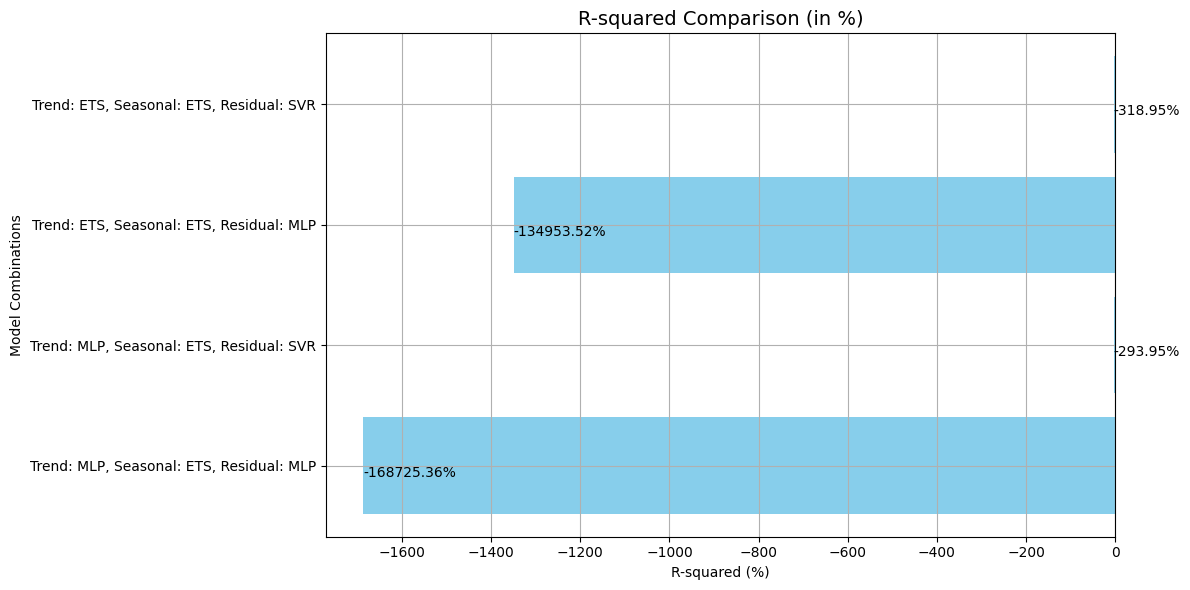

In [56]:
# Extract R-squared values for each model combination
model_combinations = list(metrics.keys())
r_squared_values = [metrics[model]['R-squared'] for model in model_combinations]

# Create a bar plot for R-squared values
plt.figure(figsize=(12, 6))
plt.barh(model_combinations, r_squared_values, color='skyblue')

# Add percentage to the title
plt.title('R-squared Comparison (in %)', fontsize=14)
plt.xlabel('R-squared (%)')
plt.ylabel('Model Combinations')

# Convert R-squared values to percentages and display them on the bars
for i, v in enumerate(r_squared_values):
    plt.text(v, i, f"{v * 100:.2f}%", va='top', ha='left', fontsize=10, color='black')

plt.grid(True)
plt.tight_layout()
plt.show()


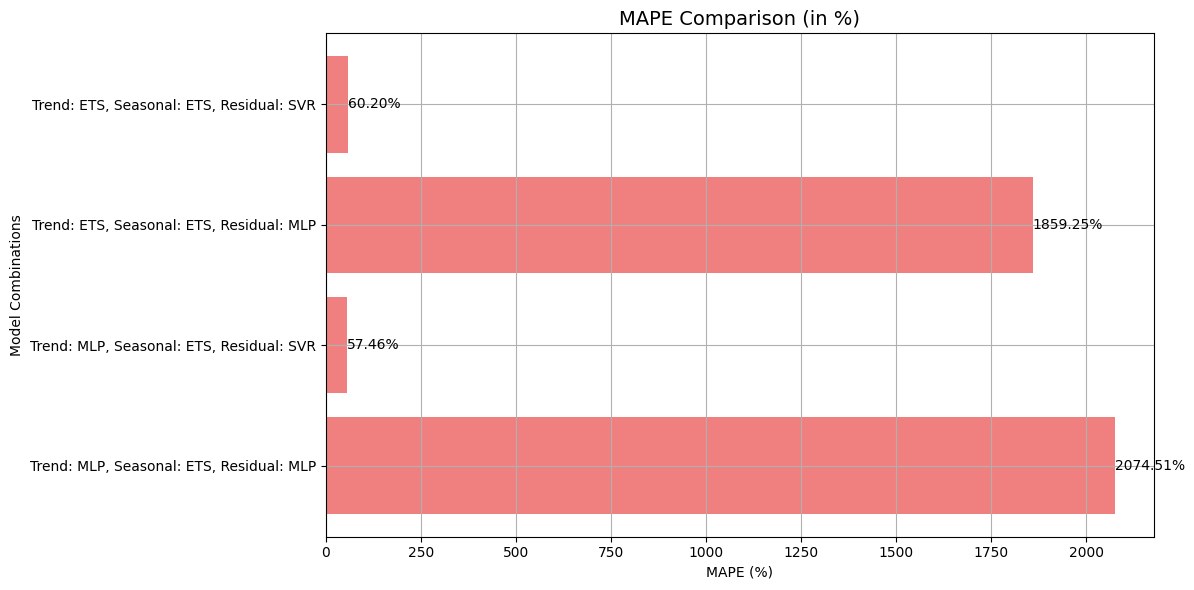

In [55]:
# Extract MAPE values for each model combination
model_combinations = list(metrics.keys())
mape_values = [metrics[model]['MAPE'] for model in model_combinations]

# Create a bar plot for MAPE values
plt.figure(figsize=(12, 6))
plt.barh(model_combinations, mape_values, color='lightcoral')

# Add percentage to the title
plt.title('MAPE Comparison (in %)', fontsize=14)
plt.xlabel('MAPE (%)')
plt.ylabel('Model Combinations')

# Display MAPE values on the bars
for i, v in enumerate(mape_values):
    plt.text(v, i, f"{v:.2f}%", va='center', ha='left', fontsize=10, color='black')

plt.grid(True)
plt.tight_layout()
plt.show()
